In [1]:
!pip install tensorflow scikit-learn matplotlib seaborn

# Load and split data
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight

In [2]:
from google.colab import files
uploaded = files.upload()

Saving reddit_comments_clean.csv to reddit_comments_clean.csv


In [3]:
# Convert to TensorFlow datasets
def prepare_dataset(texts, labels):
    texts = tf.convert_to_tensor(texts)
    labels = tf.convert_to_tensor(labels)
    ds = tf.data.Dataset.from_tensor_slices((texts, labels))
    ds = ds.shuffle(1024).batch(32).prefetch(tf.data.AUTOTUNE)
    return ds

In [4]:
df = pd.read_csv("reddit_comments_clean.csv")
texts = df['clean_text'].astype(str).tolist()
labels = df['label'].tolist()

# Split dataset
X_train, X_val, y_train, y_val = train_test_split(texts, labels, test_size=0.2, stratify=labels, random_state=42)

# Text vectorization layer
max_tokens = 10000
sequence_length = 200

vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=sequence_length
)

# Adapt vectorizer to training data
vectorizer.adapt(X_train)

In [5]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

Class weights: {0: np.float64(0.99125), 1: np.float64(1.008905852417303)}


Epoch 1/5
1983/1983 ━━━━━━━━━━━━━━━━━━━━ 572s 282ms/step - accuracy: 0.6177 - loss: 0.6379 - val_accuracy: 0.6834 - val_loss: 0.5789
Epoch 2/5
1983/1983 ━━━━━━━━━━━━━━━━━━━━ 549s 276ms/step - accuracy: 0.7291 - loss: 0.5217 - val_accuracy: 0.6808 - val_loss: 0.5926
Epoch 3/5
1983/1983 ━━━━━━━━━━━━━━━━━━━━ 568s 278ms/step - accuracy: 0.7854 - loss: 0.4329 - val_accuracy: 0.6740 - val_loss: 0.7253


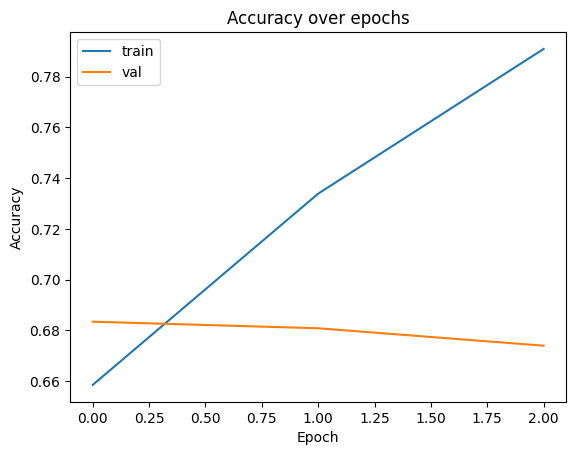

In [6]:
train_ds = prepare_dataset(X_train, y_train).map(lambda x, y: (vectorizer(x), y))
val_ds = prepare_dataset(X_val, y_val).map(lambda x, y: (vectorizer(x), y))

# Model definition
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_tokens, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)],
    class_weight=class_weight_dict
)

# Plot accuracy
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title("Accuracy over epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [7]:
def predict_user_input(input_text):
    # Ensure input is a list
    input_tensor = tf.convert_to_tensor([input_text])

    # Vectorize the input
    vectorized = vectorizer(input_tensor)

    # Predict with the model
    prediction = model.predict(vectorized)[0][0]  # Get scalar output

    # Show results
    leaning = "Liberal" if prediction > 0.5 else "Conservative"
    confidence = prediction if prediction > 0.5 else 1 - prediction
    print(f"\n Prediction: {leaning}")
    print(f"Confidence: {confidence:.2%}")

In [ ]:
# Try it out!
user_input = input("Enter a political comment to classify: ")
predict_user_input(user_input)